# Ensemble Learning
In this notebook, we continue our discussion of classifiers to determine how to rank different classifiers and assess how to use the models we have explored in an *ensemble* to leverage information from individual models together.

**Learning Objectives**

By the end of this notebook, you should be able to:
1. Assess an ROC curve to determine the relative performance of different models
2. Implement a Majority Vote classifier to leverage classifications from multiple models
3. Implement a bagging approach to build an ensemble of classifiers

**Import modules**

Begin by importing the modules to be used in this notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

### The Phytoplankton Classification Problem

Continuing with our theme of classfication, we're going to explore the data on phytoplankton collected in the in the San Francisco Bay area that is accessible [HERE](https://www.sciencebase.gov/catalog/item/598b755de4b09fa1cb0eadd9).

Let's read in the data set into a data frame:

In [5]:
df = pd.read_csv('Phytoplankton_San_Francisco_Bay_2017-2018.csv', encoding='latin1')

As in our our previous classification notebook, let's encode these species with the IDs 0 and 1:

In [6]:
df = df[df['Taxonomic Identification'].isin(['Thalassiosira spp.','Nitzschia spp.'])]

In [7]:
df.loc[df['Taxonomic Identification']=='Thalassiosira spp.', "Species_ID"] = 0
df.loc[df['Taxonomic Identification']=='Nitzschia spp.', "Species_ID"] = 1

As a reminder of what this data looks like, we can repeat our plot as before:

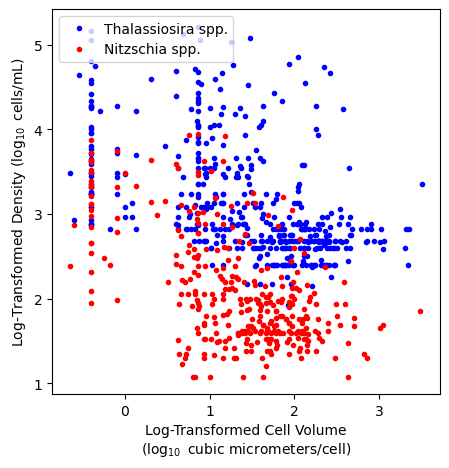

In [8]:
plt.figure(figsize=(5,5))
plt.plot(np.log10(df['Density (cells/mL)'][df['Species_ID']==0]),
         np.log10(df['Cell Volume (cubic micrometers/cell)'][df['Species_ID']==0]),
         'b.',label='Thalassiosira spp.')
plt.plot(np.log10(df['Density (cells/mL)'][df['Species_ID']==1]),
         np.log10(df['Cell Volume (cubic micrometers/cell)'][df['Species_ID']==1]),
         'r.',label='Nitzschia spp.')
plt.ylabel('Log-Transformed Density ($\\log_{10}$ cells/mL)')
plt.xlabel('Log-Transformed Cell Volume\n($\\log_{10}$ cubic micrometers/cell)')
plt.legend(loc=2)
plt.show()

As we can see, the *Thalassiosira spp.* cells tend to have higher densities and cell volumes than *Nitzschia spp.* It's important to note here that this plot is shown on a **log-scale**. 

### Implementing Different Classifiers

In this notebook, we'll continue to rely on the classification tools provided in the `scikit-learn` package. First, let's prep our design matrix and our classification data:

In [27]:
X = np.column_stack([np.log10(df['Density (cells/mL)']), np.log10(df['Cell Volume (cubic micrometers/cell)'])])
y = df['Species_ID']

In [28]:
# uncomment for demo later
# X[y==1,1] += 10

Next, let's split our data into a training set and testing set:

In [29]:
# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

Since all of the model written in `scikit-learn` have the same structure, we can use them in exactly the same way (this is the object-oriented idea of polymorphism). Let's make a list of three models examine in the previous notebook:

In [30]:
models = [LogisticRegression(),                 # Logistic Regression model
          KNeighborsClassifier(n_neighbors=3),  # K-Nearest Neighbors model
          DecisionTreeClassifier(max_depth=10)] # Decision Tree model 

Next we can fit all of our models to our data:

In [31]:
# fit all of the models
for model in models:
    model.fit(X_train, y_train)

Since we're going to make a number of the same plots, let's define some bounds to work with:

In [32]:
min_x = 0
max_x = 4
min_y = 1
max_y = 6
# uncomment for demo later
# max_y +=10

Since all of these models are written in the same way, we can apply them using the exact same code. Let's write a generalized function to apply the models to our classification dataset.

In [33]:
def classify_domain(model, X, y):
    x1 = np.linspace(min_x, max_x, 100)
    x2 = np.linspace(min_y, max_y, 100)
    X1, X2 = np.meshgrid(x1, x2)
    Y_pred = model.predict(np.column_stack([X1.ravel(), X2.ravel()])).reshape(X1.shape)
    return(X1, X2, Y_pred)

Give this function, we can compare and contrast the model results:

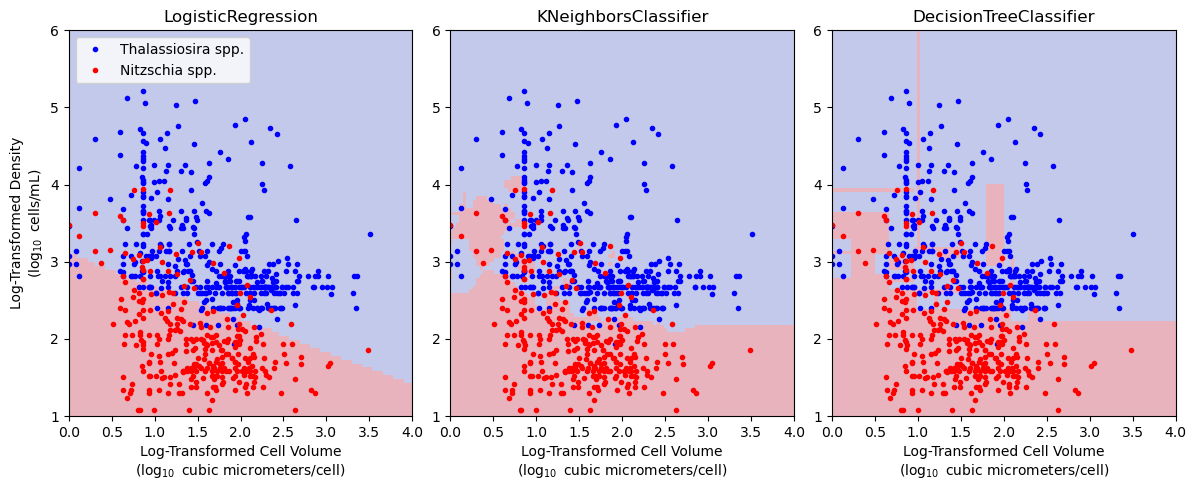

In [34]:
fig = plt.figure(figsize=(12,5))

for m, model in enumerate(models):
    X1, X2, Y_pred = classify_domain(model, X, y)
    
    plt.subplot(1, 3, m + 1)
    plt.pcolormesh(X1, X2, Y_pred, alpha=0.3, cmap='coolwarm', shading='auto')
    plt.plot(X[y==0,0], X[y==0,1],'b.',label='Thalassiosira spp.')
    plt.plot(X[y==1,0], X[y==1,1],'r.',label='Nitzschia spp.')

    plt.title(model.__class__.__name__)
    plt.gca().set_xlim([min_x, max_x])
    plt.gca().set_ylim([min_y, np.max([max_y,np.max(X[:,1])])])
    plt.xlabel('Log-Transformed Cell Volume\n($\\log_{10}$ cubic micrometers/cell)')
    
    if m==0:
        plt.ylabel('Log-Transformed Density\n($\\log_{10}$ cells/mL)')
        
        plt.legend(loc=2)
        
plt.tight_layout()
plt.show()

## ROC: Another metric to assess model performance

In our previous lesson on classifiers, we compared different models by looking at the loss function - a metric for how many points were classified right vs wrong. However, this ignores some potentially important information. Namely it ignores the tradeoff between correctly classified points and falsely misclassified points. 

To add some additional information, we can consider, for a given classification, four different quantities: 
- TP = True Positives
- FP = False Positives
- TN = True Negatives
- FN = False Negatives

Using this terminology, we can define the accuracy of our model to be 

$$
\text{Accuracy} = \frac{\text{TP} + \text{TN}}{\text{TP} + \text{TN} + \text{FP} + \text{FN}}
$$

Using these definitions, we can define two useful quantities: the true positive rate (TPR), defined as

$$
\text{TPR} = \frac{\text{TP}}{\text{TP} + \text{FN}}
$$

and the false positive rate (FPR), defined as:
$$
\text{FPR} = \frac{\text{FP}}{\text{FP} + \text{TN}}
$$

The true positive rate is the ratio between the correctly identified positive cases relative to the total number of positive cases. Similarly, the false positive rate is the number of incorrectly identified cases relative to the total number of negative cases.

Using these quantities, we can trace out a *Receiver Operating Characteristic* (ROC) curve which plots TPR and FPR as a function of a given cutoff threshold in the model probabilities. Let's have a look:

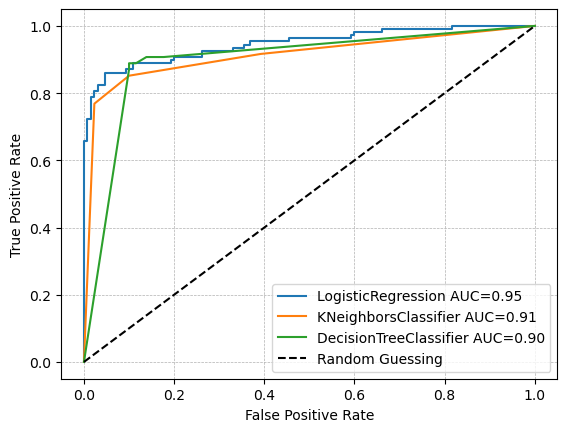

In [35]:
# loop through each of the 
for model in models:

    # fit the model and predict the probabilties
    model.fit(X_train, y_train)
    probabilities = model.predict_proba(X_test)
    
    # compute the fpr, tpr using the roc_curve function
    fpr, tpr, _ = roc_curve(y_test, probabilities[:,1], pos_label = 1)

    # compute the auc score
    auc = roc_auc_score(y_test, probabilities[:,1])

    # plot the curve and label with the model name
    plt.plot(fpr, tpr, label = model.__class__.__name__+' AUC=' + '{:.2f}'.format(auc))

# add a random guessing line
plt.plot([0,1],[0,1],'k--', label='Random Guessing')

# format the axes
plt.grid(linestyle='--',linewidth=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In the above example, we can see that the legend also has an AUC score associated with each model - this is the *area under the curve* of the ROC curve. When this value is 1 the model is a perfect classifier. At 0.5, the model is no better than random guessing.

## Majority Voting with Classifiers

Another way that we can use our models is to consider the information from all of them simultaneously. That is, we can consider what the classification prediction is for each one. One simple way to accomplish this classification is the *majority vote* classifier. That is, given a set of input features, what is the classification assigned to this point by most of the models considered?

In statistics, we say the most common number in a set is known as the *mode*, so we could express the majority vote classifier as

$$
C =  \underset{i}{\text{mode}} (C_i)
$$

where $i$ is the index of the classifiers considered. Since this approach uses a collection of different models, it is an example of **ensemble learning**.

In `scikit-learn`, we can fit and implement a majority vote classifier just like any other model. We just need to make a list of our "voters" as follows:

In [50]:
# make a list of "voters"
voters = [('Perceptron', Perceptron()),
         ('LogisticRegression', LogisticRegression()),
         ('KNN', KNeighborsClassifier(n_neighbors = 3)),
         ('DecisionTree', DecisionTreeClassifier(max_depth = 10))]

# make a voting classification model
voting_clf = VotingClassifier(voters)

Once we've got our model implemented, we just need to "fit" it like any other model:

In [51]:
# fit the voting classification model
voting_clf.fit(X_train, y_train)

# use it to predict the classes
y_pred_vote = voting_clf.predict(X_test)

Let's check out our results:

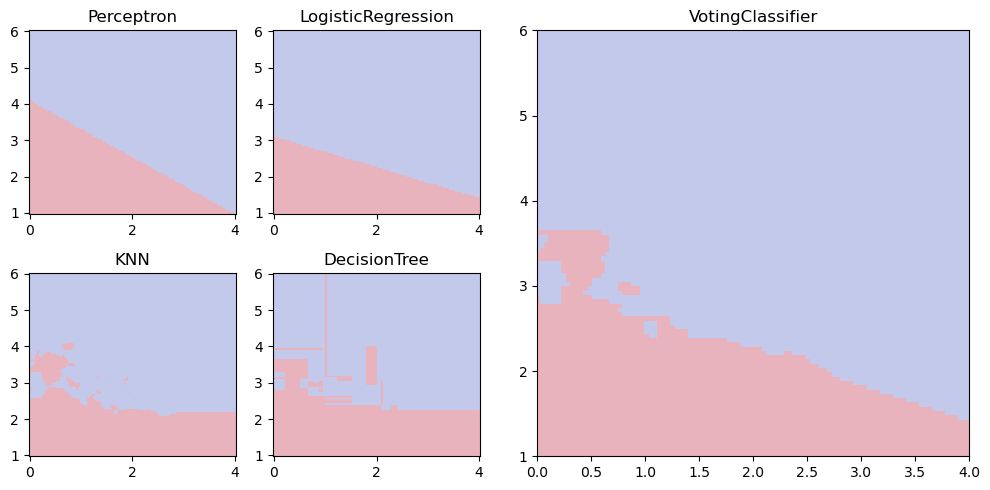

In [52]:
plt.figure(figsize=(10,5))
for i, p in enumerate([1,2,5,6]):
    model = voters[i][1]
    model.fit(X_train, y_train)
    X1, X2, Y_pred = classify_domain(model, X, y)
    plt.subplot(2,4,p)
    plt.pcolormesh(X1, X2,  Y_pred, alpha=0.3, cmap='coolwarm', shading='auto')
    plt.title(voters[i][0])

plt.subplot(1,2,2)
X1, X2, Y_pred_vote = classify_domain(voting_clf, X, y)
plt.pcolormesh(X1, X2,  Y_pred_vote, alpha=0.3, cmap='coolwarm', shading='auto')

plt.title(voting_clf.__class__.__name__)
plt.gca().set_xlim([min_x, max_x])
plt.gca().set_ylim([min_y, max_y])
plt.tight_layout()

As we can see in the comparison above, our majority voting classifier has elements of each of our individual models.

#### Weighting Classifiers
In the above example, we implicitly assumed that we were equally confident in each of our classifiers was giving us equal information. However, that may not always be true - for example, we know from our previous lesson that the KNN model has a tendency to overfit, especially with a small number of neighbors used for the training. In this cases, we could consider *weighting* this model less than the other models to 

In [53]:
voters = [('Perceptron',Perceptron()),
          ('LogitisticRegression',LogisticRegression()),
          ('KNN',KNeighborsClassifier(n_neighbors=3)),
          ('DecisionTree',DecisionTreeClassifier(max_depth=10))]

# implement the voting classifier with weights
voting_clf = VotingClassifier(voters, weights = [0.1, 0.3, 0.3, 0.3])

# fit the model and use it to predict the classifications
voting_clf.fit(X_train, y_train)
y_pred_vote = voting_clf.predict(X_test)

Let's revisit the plot above to see how it looks:

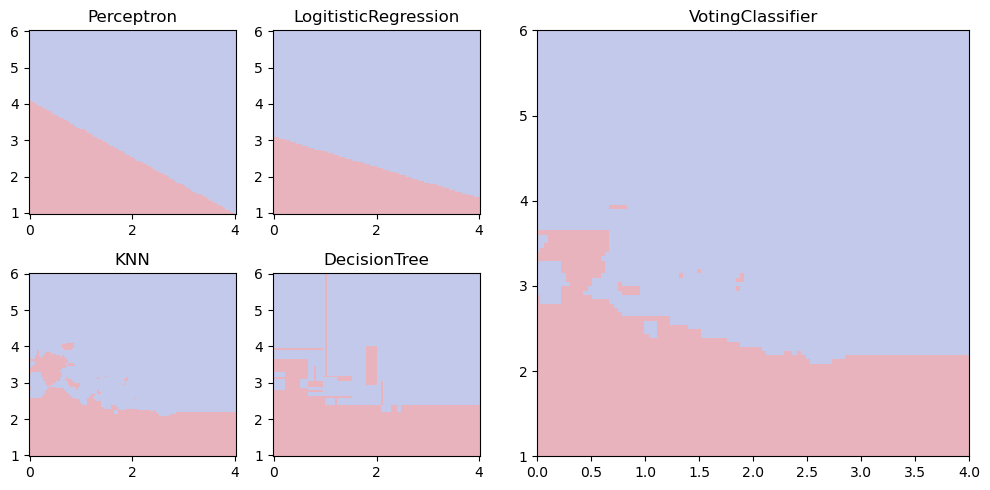

In [54]:
plt.figure(figsize=(10,5))
for i, p in enumerate([1,2,5,6]):
    model = voters[i][1]
    model.fit(X_train, y_train)
    X1, X2, Y_pred = classify_domain(model, X, y)
    plt.subplot(2,4,p)
    plt.pcolormesh(X1, X2,  Y_pred, alpha=0.3, cmap='coolwarm', shading='auto')
    plt.title(voters[i][0])

plt.subplot(1,2,2)
X1, X2, Y_pred_vote = classify_domain(voting_clf, X, y)
plt.pcolormesh(X1, X2,  Y_pred_vote, alpha=0.3, cmap='coolwarm', shading='auto')

plt.title(voting_clf.__class__.__name__)
plt.gca().set_xlim([min_x, max_x])
plt.gca().set_ylim([min_y, max_y])
plt.tight_layout()

## Bagging
With the majority voting concept in hand, we can consider another approach for reducing variance in our model results - bagging. To motivate the concept of bagging, consider the results of the Decision tree classifier above. Clearly, this classification is built on a very specific training example, giving rise to all of the funky shapes in the classification domain. The idea of bagging is to use multiple models trained on different subsets of data and then *aggregrating* the results with majority voting.

The key question to consider is: how do we generate lots of different datasets when we only have a finite amount of test data? The approach used in bagging is *bootstrap sampling* - that is, choosing a random sampling of points in the data set as a test set. 

Thus **bagg**ing is the **agg**regating of model results trained on **b**ootstrap samples.

Let's take a look at a classic example using a decision tree classifier:

In [56]:
# make a bagging classifier and fit it to the data
bagging_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators = 100, random_state = 17)
bagging_clf.fit(X_train, y_train)

,estimator,DecisionTreeClassifier()
,n_estimators,100
,max_samples,1.0
,max_features,1.0
,bootstrap,True
,bootstrap_features,False
,oob_score,False
,warm_start,False
,n_jobs,None
,random_state,17
,verbose,0


Let's take a look at the results:

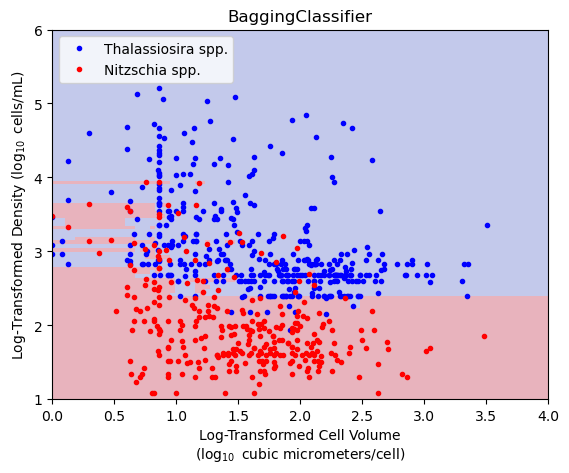

In [57]:
# generate the plot
X1, X2, Y_pred_bag = classify_domain(bagging_clf, X, y)
plt.pcolormesh(X1, X2,  Y_pred_bag, alpha=0.3, cmap='coolwarm', shading='auto')
plt.plot(np.log10(df['Density (cells/mL)'][df['Species_ID']==0]),
         np.log10(df['Cell Volume (cubic micrometers/cell)'][df['Species_ID']==0]),
         'b.',label='Thalassiosira spp.')
plt.plot(np.log10(df['Density (cells/mL)'][df['Species_ID']==1]),
     np.log10(df['Cell Volume (cubic micrometers/cell)'][df['Species_ID']==1]),
     'r.',label='Nitzschia spp.')

# format the axes
plt.title(bagging_clf.__class__.__name__)
plt.gca().set_xlim([min_x, max_x])
plt.gca().set_ylim([min_y, max_y])
plt.ylabel('Log-Transformed Density ($\\log_{10}$ cells/mL)')
plt.xlabel('Log-Transformed Cell Volume\n($\\log_{10}$ cubic micrometers/cell)')
plt.legend(loc=2)
plt.show()

Here, we can see that the aggregate of the Decision Tree models produces far less "random blocks" than in the individual case. This model would be more generalizable to unseen data because the model is not trained on a specific subset of the data.

Since this model is built as a collection of a Decision Trees, this type of model is often referred to as a "Random Forest". However, in a random forest, the feature depth is often allowed to vary. Turns out this is also implemented in `scikit-learn`:

In [60]:
# make a random forest classifier and fit it on the training data
rf_clf = RandomForestClassifier(n_estimators = 100, max_depth = None, random_state = 17)
rf_clf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Let's check out the results:

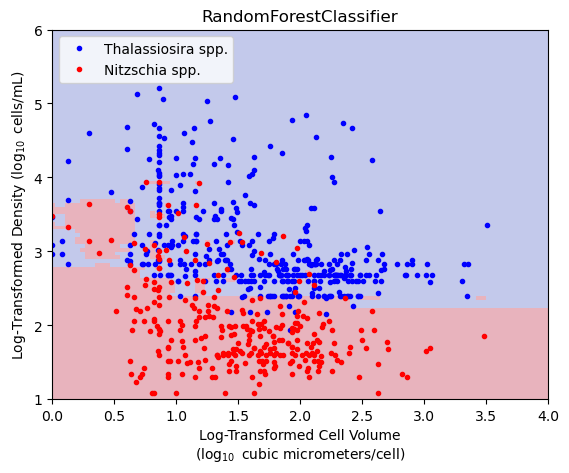

In [61]:
# generate the plot
X1, X2, Y_pred_bag = classify_domain(rf_clf, X, y)
plt.pcolormesh(X1, X2,  Y_pred_bag, alpha=0.3, cmap='coolwarm', shading='auto')
plt.plot(np.log10(df['Density (cells/mL)'][df['Species_ID']==0]),
         np.log10(df['Cell Volume (cubic micrometers/cell)'][df['Species_ID']==0]),
         'b.',label='Thalassiosira spp.')
plt.plot(np.log10(df['Density (cells/mL)'][df['Species_ID']==1]),
     np.log10(df['Cell Volume (cubic micrometers/cell)'][df['Species_ID']==1]),
     'r.',label='Nitzschia spp.')

# format the axes
plt.title(rf_clf.__class__.__name__)
plt.gca().set_xlim([min_x, max_x])
plt.gca().set_ylim([min_y, max_y])
plt.ylabel('Log-Transformed Density ($\\log_{10}$ cells/mL)')
plt.xlabel('Log-Transformed Cell Volume\n($\\log_{10}$ cubic micrometers/cell)')
plt.legend(loc=2)
plt.show()

**Key Takeaways**

1. An ROC curve provides useful information on the relative rates of true positive and false positives.
2. Classification models can be used in an ensemble to leverage information from multiple models at once.
3. Bagging allows a user to train a collection of models on different subsets of data and then combine those models using a majority voting approach.